#**IRWA 2024 - PROJECT**
#**Part 2: Indexing and Evaluation**
##**G102_2**

Roger Sola (u199780)

Queralt Zamora (u199903)

Clàudia Morales (u199906)




#**Initialize**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# TO BE MODIFIED WITH THE DIRECTORY FROM THE TEACHER

#docs_path = 'farmers-protest-tweets.json'
docs_path = '/content/drive/MyDrive/1st TERM/RIAW/LABS/PART 1/data/farmers-protest-tweets.json' #queralt
#docs_path = '/content/drive/MyDrive/UNI/UPF/4t Any/RIAW/LABS/PART 1/data/farmers-protest-tweets.json'#claud
#docs_path = '/content/drive/MyDrive/4t/T1/RIAW/LABS/PART 1/data/farmers-protest-tweets.json'

In [ ]:
# TO BE MODIFIED WITH THE DIRECTORY FROM THE TEACHER

#ids_path = 'tweet_document_ids_map.csv'
ids_path = '/content/drive/MyDrive/1st TERM/RIAW/LABS/PART 1/data/tweet_document_ids_map.csv' #queralt
#ids_path  = '/content/drive/MyDrive/UNI/UPF/4t Any/RIAW/LABS/PART 1/data/tweet_document_ids_map.csv' #claudia
#ids_path  = '/content/drive/MyDrive/4t/T1/RIAW/LABS/PART 1/data/tweet_document_ids_map.csv' #roger

In [ ]:
# TO BE MODIFIED WITH THE DIRECTORY FROM THE TEACHER

evaluation_path = '/content/drive/MyDrive/1st TERM/RIAW/LABS/PART 2/inputs/evaluation_gt.csv' #queralt
#evaluation_path = '/content/drive/MyDrive/UNI/UPF/4t Any/RIAW/LABS/PART 2/inputs/evaluation_gt.csv' #claudia

In [ ]:
import json
import nltk
import re
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
from string import punctuation
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from collections import Counter
from wordcloud import WordCloud
import string
import spacy
from IPython.display import Markdown, display
import numpy as np
from collections import defaultdict
import time
from array import array
import collections
from numpy import linalg as la
import math
import random
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.manifold import TSNE
#np.random.seed(42)

#**PART 1: Preprocessing Data and Analysis**

#**Preprocessing Data**##

<font size="+2">2. Preprocessing Data</font>

1.  *Removing stop words*
1.  *Tokenization*
2.  *Removing punctuation marks*
1.  *Stemming*
2.  *and... anything else you think it's needed (bonus point)*

*HINTS:*

*1. Take into account that for future queries, the final output must return (when present)
the following information for each of the selected documents: Tweet | Date | Hashtags
| Likes | Retweets | Url (here the “Url” means the tweet link).*

*2. Consider your approach to hashtags during pre-processing, such as the decision to retain
or remove the "#" symbol. Their distinctiveness might be valuable when treated as
separate terms in the inverted index. As guidance, turn to the evaluation file
(evaluation_gt) which will become pivotal in the project’s second phase. Using a subset
of the dataset, the evaluation_gt sets a baseline with three distinct information needs
and their respective ground truths, indicating if a document is relevant (1) or not (0) to
an information need. For context, one of these information needs relates to discussions
about Indian goverment. Reflect on how this context might shape your strategy for
hashtag handling.*

*3. Suggested library that may help you in stemming and stop words: nltk*


*Make sure you map the tweet’s Ids with the document ids as the document Ids will be
considered for the evaluation stage of the project (tweet_document_ids_map).*

In [ ]:
def create_markdown(title):
    display(Markdown(f'### {title}'))

nltk.download('punkt')
nltk.download('stopwords')

stop_words = set(stopwords.words('english'))
stemmer = PorterStemmer()

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


<font size="+1">2.1. - 2.5. Preprocessesing function
</font>

In [ ]:
# preprocessing function
def preprocess_text(text):
    text = text.lower() # 2.1. convert text to lowercase
    text = re.sub(r'http\S+|www\S+', '', text) # 2.2. remove URLs
    hashtags = re.findall(r'#\S+', text) # 2.3. extract hashtags separately (HINT 2)
    text = re.sub(r'#\w+', '', text) # 2.3. delete hastags from main tweet (HINT 2)
    # more preprocess methods
    text = text.strip() # 2.4. removing spaces at the beginning and spaces at the end
    text = re.sub(r'\s+', ' ', text) # 2.4. changing double spaces to single spaces.

    # NEW: we eliminate everything that is not alphanumeric characters
    text = re.sub(r'[^a-zA-Z0-9\s]+', '', text)

    tokens = word_tokenize(text) # 2.5. tokenize text
    filtered_tokens = [stemmer.stem(word) for word in tokens if word not in stop_words and word not in punctuation ] # remove punctuation and stop words, and apply stemming

    return filtered_tokens, hashtags

<font size="+1">2.6. Preprocessed Tweets storage
</font>

In [ ]:
# 2.6. read and preprocess the data line by line from .json file
preprocessed_tweets = []
with open(docs_path, 'r') as file:
    for line in file:
        try:
            tweet = json.loads(line)

            # extract relevant information
            tweet_id = tweet.get('id')
            content = tweet.get('content')
            preprocessed_content,hashtags = preprocess_text(content)
            preprocessed_tweets.append({
                'id': tweet_id,
                'preprocessed_content': preprocessed_content,
                'date': tweet.get('date'),
                'hashtags': hashtags,
                'likes': tweet.get('likeCount'),
                'retweets': tweet.get('retweetCount'),
                'url': tweet.get('url')
            })
        except json.JSONDecodeError as e:
            print(f"Error parsing line: {e}")

In [ ]:
# function to contain all necessary tweet and document information
def return_tweet_info(preprocessed_tweets):

    df = pd.DataFrame(preprocessed_tweets) # create DataFrame

    # new dataframe with desired information
    tweet_info = pd.DataFrame({
        'Tweet ID': df['id'],
        'Tweet': df['preprocessed_content'].apply(lambda x: ' '.join(x)),
        'Date': df['date'],
        'Hashtags': df['hashtags'].apply(lambda x: ', '.join(x) if x else 'None'),
        'Likes': df['likes'],
        'Retweets': df['retweets'],
        'Url': df['url']
    })

    return tweet_info

In [ ]:
tweet_info_df = return_tweet_info(preprocessed_tweets)
display(tweet_info_df)

,Tweet ID,Tweet,Date,Hashtags,Likes,Retweets,Url
0,1364506249291784198,world progress indian polic govt still tri tak...,2021-02-24T09:23:35+00:00,"#modidontsellfarmers, #farmersprotest, #freeno...",0,0,https://twitter.com/ArjunSinghPanam/status/136...
1,1364506237451313155,kisanektamorcha farmer constantli distroy crop...,2021-02-24T09:23:32+00:00,"#farmersprotest, #modiignoringfarmersdeaths, #...",0,0,https://twitter.com/PrdeepNain/status/13645062...
2,1364506195453767680,,2021-02-24T09:23:22+00:00,#farmersprotest,0,0,https://twitter.com/parmarmaninder/status/1364...
3,1364506167226032128,reallyswara rohinisgh watch full video,2021-02-24T09:23:16+00:00,"#farmersprotest, #nofarmersnofood",0,0,https://twitter.com/anmoldhaliwal/status/13645...
4,1364506144002088963,,2021-02-24T09:23:10+00:00,"#kisanektamorcha, #farmersprotest, #nofarmersn...",0,0,https://twitter.com/KotiaPreet/status/13645061...
...,...,...,...,...,...,...,...
117402,1360040182771163138,,2021-02-12T01:37:02+00:00,"#farmersprotest, #kisanandolan, #kisaanmajdoor...",0,0,https://twitter.com/rickyrickstir/status/13600...
117403,1360040146402373637,pm punjabtak,2021-02-12T01:36:53+00:00,"#farmersprotest, #kisanaandolan, #farmersfury,...",0,0,https://twitter.com/PunjabTak/status/136004014...
117404,1360040134230556678,unit stand divid fall,2021-02-12T01:36:50+00:00,"#mahapanchayatrevolution, #farmersprotest",39,65,https://twitter.com/ish_kayy/status/1360040134...
117405,1360040127679000577,,2021-02-12T01:36:49+00:00,"#farmersprotest, #msp, #farmbill2020, #singhub...",15,1,https://twitter.com/TV9Bharatvarsh/status/1360...


<font size="+1">2.7. Map IDs</font>

In [ ]:
# 2.7. map the tweet’s ids with the document ids
# ids csv loaded
tweet_ids_map = pd.read_csv(ids_path)
display(tweet_ids_map)

,docId,id
0,doc_0,1364506249291784198
1,doc_1,1364506237451313155
2,doc_2,1364506167226032128
3,doc_3,1364505991887347714
4,doc_4,1364505813834989568
...,...,...
48424,doc_48424,1360040232733708294
48425,doc_48425,1360040229265022979
48426,doc_48426,1360040195786067969
48427,doc_48427,1360040134230556678


In [ ]:
# merged the tweet_info_df with the tweet_ids_map based on the 'Tweet ID' column
# 'id' in tweet_ids_map corresponds to 'Tweet ID' in tweet_info_df
tweet_info_df = tweet_info_df.merge(tweet_ids_map, left_on='Tweet ID', right_on='id', how='left')

# renamed 'docid' column from tweet_ids_map to 'Document ID' in the merged DataFrame
tweet_info_df = tweet_info_df.rename(columns={'docId': 'Document ID'})

# drop the column 'id' to not have repeated columns
tweet_info_df = tweet_info_df.drop(columns=['id'])

# NEW: drop the rows without doc_id
tweet_info_df = tweet_info_df.dropna(subset=['Document ID'])

display(tweet_info_df)

,Tweet ID,Tweet,Date,Hashtags,Likes,Retweets,Url,Document ID
0,1364506249291784198,world progress indian polic govt still tri tak...,2021-02-24T09:23:35+00:00,"#modidontsellfarmers, #farmersprotest, #freeno...",0,0,https://twitter.com/ArjunSinghPanam/status/136...,doc_0
1,1364506237451313155,kisanektamorcha farmer constantli distroy crop...,2021-02-24T09:23:32+00:00,"#farmersprotest, #modiignoringfarmersdeaths, #...",0,0,https://twitter.com/PrdeepNain/status/13645062...,doc_1
3,1364506167226032128,reallyswara rohinisgh watch full video,2021-02-24T09:23:16+00:00,"#farmersprotest, #nofarmersnofood",0,0,https://twitter.com/anmoldhaliwal/status/13645...,doc_2
8,1364505991887347714,mandeeppunia1 watch full video,2021-02-24T09:22:34+00:00,"#farmersprotest, #nofarmersnofood",0,0,https://twitter.com/anmoldhaliwal/status/13645...,doc_3
11,1364505813834989568,mandeeppunia1 watch full video,2021-02-24T09:21:51+00:00,"#farmersprotest, #nofarmersnofood",0,0,https://twitter.com/anmoldhaliwal/status/13645...,doc_4
...,...,...,...,...,...,...,...,...
117395,1360040232733708294,modi want make slave free india come join farm...,2021-02-12T01:37:14+00:00,"#mahapanchayatrevolution, #farmersprotest",208,246,https://twitter.com/AntiITcellTask1/status/136...,doc_48424
117397,1360040229265022979,farmer agit longer confin border one state far...,2021-02-12T01:37:13+00:00,"#mahapanchayatrevolution, #farmersprotest",22,31,https://twitter.com/rupindr79/status/136004022...,doc_48425
117400,1360040195786067969,first mahapanchayat punjab revolut gain strength,2021-02-12T01:37:05+00:00,"#mahapanchayatrevolution, #farmersprotest",18,43,https://twitter.com/PushpSamra/status/13600401...,doc_48426
117404,1360040134230556678,unit stand divid fall,2021-02-12T01:36:50+00:00,"#mahapanchayatrevolution, #farmersprotest",39,65,https://twitter.com/ish_kayy/status/1360040134...,doc_48427


In [ ]:
print('There are a total of',len(tweet_info_df),'tweets')

There are a total of 48429 tweets


In [ ]:
# verify the number of entries maped
print(f"Number of entries maped: {len(tweet_ids_map)}")

Number of entries maped: 48429


<font size="+1">2.8. Output display</font>

In [ ]:
# 2.8. printing method as demanded (HINT 1)
print("Tweet | Date | Hashtags | Likes | Retweets | Url")
print()
for index, row in tweet_info_df.head().iterrows():
    print(index, f"| {row['Tweet']} | {row['Date']} | {row['Hashtags']} | {row['Likes']} | {row['Retweets']} | {row['Url']}")

# print one of the most retweeted tweets to see if the variables of the number of likes/retweets are correctly created.
most_retweeted_tweet = tweet_info_df.iloc[111]
print(f"{most_retweeted_tweet.name} | {most_retweeted_tweet['Tweet']} | {most_retweeted_tweet['Date']} | {most_retweeted_tweet['Hashtags']} | {most_retweeted_tweet['Likes']} | {most_retweeted_tweet['Retweets']} | {most_retweeted_tweet['Url']}")

Tweet | Date | Hashtags | Likes | Retweets | Url

0 | world progress indian polic govt still tri take india back horrif past tyranni narendramodi delhipolic shame | 2021-02-24T09:23:35+00:00 | #modidontsellfarmers, #farmersprotest, #freenodeepkaur | 0 | 0 | https://twitter.com/ArjunSinghPanam/status/1364506249291784198
1 | kisanektamorcha farmer constantli distroy crop throughout india realli heart breakingw care crop like children govt agricultur minist laugh usw win | 2021-02-24T09:23:32+00:00 | #farmersprotest, #modiignoringfarmersdeaths, #modidontsellfarmers | 0 | 0 | https://twitter.com/PrdeepNain/status/1364506237451313155
3 | reallyswara rohinisgh watch full video | 2021-02-24T09:23:16+00:00 | #farmersprotest, #nofarmersnofood | 0 | 0 | https://twitter.com/anmoldhaliwal/status/1364506167226032128
8 | mandeeppunia1 watch full video | 2021-02-24T09:22:34+00:00 | #farmersprotest, #nofarmersnofood | 0 | 0 | https://twitter.com/anmoldhaliwal/status/1364505991887347714
11 | mandeeppun

It was decided to not take out the emogis since then, the special characters in indian would be also be deleted, leaving some tweets in blank.

#**Data analysis**##

<font size="+2">3. Data Analysis</font>

*When working with data, it is important to have a better understanding of the content and
some statistics. Provide an exploratory data analysis to describe the dataset you are working on
in this project and explain the decisions made for the analysis. For example, word counting
distribution, average sentence length, vocabulary size, ranking of tweets most retweeted, word
clouds for the most frequent words, and entity recognition. Feel free to do the exploratory
analysis and report your findings in the report.*

<font size="+1">3.1. Word count distribution</font>

In [ ]:
# 3.1. Word count distribution
word_count = tweet_info_df['Tweet'].apply(lambda x: len(x.split())) # num of words per tweet
'''
# create_markdown("1. Word count distribution")
plt.figure(figsize=(10, 6))
sns.histplot(word_count, kde=True, bins=30, color = 'purple')
plt.title('Word Count Distribution Across Tweets')
plt.xlabel('Number of Words')
plt.ylabel('Frequency')
plt.show()
'''

'\n# create_markdown("1. Word count distribution")\nplt.figure(figsize=(10, 6))\nsns.histplot(word_count, kde=True, bins=30, color = \'purple\')\nplt.title(\'Word Count Distribution Across Tweets\')\nplt.xlabel(\'Number of Words\')\nplt.ylabel(\'Frequency\')\nplt.show()\n'

The number of words in tweets seems to follow a geometric (or exponential) distribution. Therefore, we can say that tweets tend to be short texts. In fact, there is a peak at the beginning, indicating that most of them do not exceed 5 to 10 words.

<font size="+1">3.2. Average sentence length</font>

In [ ]:
# 3.2. Average sentence length

#create_markdown("2. Average sentence length")
average_sentence_length = word_count.mean()
print(f"Average number of words per tweet: {average_sentence_length:.2f}")

Average number of words per tweet: 11.26


We calculated the average sentence length across all tweets to provide how much the users tend to write in their tweets. In the result, we can see that the average tweet length contains around 10 words which makes sense observing the previous section. This tells us that most users are concise at the moment to write their tweets.

<font size="+1">3.3. Vocabulary size</font>

In [ ]:
# 3.3. Vocabulary size

#create_markdown("3. Vocabulary size")
all_words = ' '.join(tweet_info_df['Tweet']).split() # combine all words from the tweets
vocabulary = set(all_words)
vocab_size = len(vocabulary)# Count unique words (vocabulary size)
print(f"Vocabulary size (unique words): {vocab_size}")

Vocabulary size (unique words): 32246


To observe the diversity of the language used in the dataset we calculated the vocabulary size, the number of unique words across all tweets. We get as a result a total of 104894 unique words, indicating a rich and diverse use of the language.

<font size="+1">3.4. Ranking of tweets based on Likes and Retweets</font>

In [ ]:
# 3.4. Ranking of tweets based on Likes and Retweets
'''
create_markdown("Ranking of tweets based on Likes and Retweets")

top_retweeted = tweet_info_df[['Tweet', 'Retweets', 'Url']].sort_values(by='Retweets', ascending=False).head(10)
create_markdown("Top 10 Most Retweeted Tweets:")
display(top_retweeted)

top_liked = tweet_info_df[['Tweet', 'Likes', 'Url']].sort_values(by='Likes', ascending=False).head(10)
create_markdown("Top 10 Liked Tweets:")
display(top_liked)
'''

'\ncreate_markdown("Ranking of tweets based on Likes and Retweets")\n\ntop_retweeted = tweet_info_df[[\'Tweet\', \'Retweets\', \'Url\']].sort_values(by=\'Retweets\', ascending=False).head(10)\ncreate_markdown("Top 10 Most Retweeted Tweets:")\ndisplay(top_retweeted)\n\ntop_liked = tweet_info_df[[\'Tweet\', \'Likes\', \'Url\']].sort_values(by=\'Likes\', ascending=False).head(10)\ncreate_markdown("Top 10 Liked Tweets:")\ndisplay(top_liked)\n'

Analysing the previous results, we can see that 7 out of 10 in each top list coincide. Therefore, a tweet with many retweets is likely to have more likes and a tweet with many likes is likely to have more retweets.

<font size="+1"> 3.5. WordCloud of the most frequent words</font>

In [ ]:
# 3.5. WordCloud of the most frequent words
'''
#create_markdown("WordCloud of the most frequent words")

# filter out stop words and punctuation, and count word frequencies
word_frequencies = Counter(
    word.strip(string.punctuation).lower() for word in all_words
    if word.lower() not in stop_words and word.strip(string.punctuation) != '' and word.isalpha() #special characters and punctuations out
)

# generate the word cloud
wordcloud = WordCloud(width=800, height=400,colormap='magma_r', background_color='white').generate_from_frequencies(word_frequencies)
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Most Frequent Words in Tweets')
plt.show()
'''

'\n#create_markdown("WordCloud of the most frequent words")\n\n# filter out stop words and punctuation, and count word frequencies\nword_frequencies = Counter(\n    word.strip(string.punctuation).lower() for word in all_words\n    if word.lower() not in stop_words and word.strip(string.punctuation) != \'\' and word.isalpha() #special characters and punctuations out\n)\n\n# generate the word cloud\nwordcloud = WordCloud(width=800, height=400,colormap=\'magma_r\', background_color=\'white\').generate_from_frequencies(word_frequencies)\nplt.figure(figsize=(10, 6))\nplt.imshow(wordcloud, interpolation=\'bilinear\')\nplt.axis(\'off\')\nplt.title(\'Most Frequent Words in Tweets\')\nplt.show()\n'

The most frequent words make quite a lot of sense if we consider the main topic of these tweets: "Farmers Protests of 2021." Therefore, we can see that 'farmer' is the most significant word, apart from 'support', 'protest', and 'india'. Additionally, it could be deduced that these protests took place in India, if it was the case that we did not have this information.

<font size="+1">3.6. Hashtags Analysis</font>

In [ ]:
# 3.6. Hashtags Analysis
'''
create_markdown("Top 10 Most common hashtags")
all_hashtags = []

# iterate over each row in the 'Hashtags' column
for hashtags in tweet_info_df['Hashtags']:

    # extract hashtags that start with '#' and stop before a space/comma
    extracted_hashtags = re.findall(r'#\S+[^,\s]', hashtags)
    all_hashtags.extend(extracted_hashtags)

# count the frequency of each hashtag
hashtag_counts = Counter(all_hashtags)

hashtag_df = pd.DataFrame(hashtag_counts.items(), columns=['Hashtag', 'Count'])
hashtag_df = hashtag_df.sort_values(by='Count', ascending=False).reset_index(drop=True)
display(hashtag_df.head(10))
'''

'\ncreate_markdown("Top 10 Most common hashtags")\nall_hashtags = []\n\n# iterate over each row in the \'Hashtags\' column\nfor hashtags in tweet_info_df[\'Hashtags\']:\n\n    # extract hashtags that start with \'#\' and stop before a space/comma\n    extracted_hashtags = re.findall(r\'#\\S+[^,\\s]\', hashtags)\n    all_hashtags.extend(extracted_hashtags)\n\n# count the frequency of each hashtag\nhashtag_counts = Counter(all_hashtags)\n\nhashtag_df = pd.DataFrame(hashtag_counts.items(), columns=[\'Hashtag\', \'Count\'])\nhashtag_df = hashtag_df.sort_values(by=\'Count\', ascending=False).reset_index(drop=True)\ndisplay(hashtag_df.head(10))\n'

In [ ]:
'''
top_hashtags = hashtag_counts.most_common(10)
labels, values = zip(*top_hashtags)

plt.figure(figsize=(15, 6))

# plot 1
plt.subplot(1, 2, 1)  # (rows, columns, panel number)
plt.bar(labels, values, color='pink')
plt.title('Top 10 Most Common Hashtags')
plt.xlabel('Hashtags')
plt.ylabel('Frequency')
plt.xticks(rotation=70)

# plot 2
plt.subplot(1, 2, 2)  # (rows, columns, panel number)
log_values = np.log1p(values)  # Using log1p for stability (log(1 + x))
plt.bar(labels, log_values, color='pink')
plt.title('Top 10 Most Common Hashtags (Log Scale)')
plt.xlabel('Hashtags')
plt.ylabel('Log(Frequency)')
plt.xticks(rotation=70)

plt.tight_layout()  # Adjust layout to prevent overlap
plt.show()
'''

"\ntop_hashtags = hashtag_counts.most_common(10)\nlabels, values = zip(*top_hashtags)\n\nplt.figure(figsize=(15, 6))\n\n# plot 1\nplt.subplot(1, 2, 1)  # (rows, columns, panel number)\nplt.bar(labels, values, color='pink')\nplt.title('Top 10 Most Common Hashtags')\nplt.xlabel('Hashtags')\nplt.ylabel('Frequency')\nplt.xticks(rotation=70)\n\n# plot 2\nplt.subplot(1, 2, 2)  # (rows, columns, panel number)\nlog_values = np.log1p(values)  # Using log1p for stability (log(1 + x))\nplt.bar(labels, log_values, color='pink')\nplt.title('Top 10 Most Common Hashtags (Log Scale)')\nplt.xlabel('Hashtags')\nplt.ylabel('Log(Frequency)')\nplt.xticks(rotation=70)\n\nplt.tight_layout()  # Adjust layout to prevent overlap\nplt.show()\n"

In this sixth section, the table and plot reveal that the hashtag #FarmersProtest stands out as the most popular, significantly outpacing the others. However, due to the scale used in the plot, it is really difficult to see the differences in popularity among the remaining hashtags. So we applied a logarithmic scale to enhance visual clarity and make the differences more clear.

<font size="+1">3.7. Relation between number of likes and number of hashtags
</font>

It is believed that tweets with more hashtags tend to receive more likes. In other words, a higher number of hashtags is associated with a greater number of likes.

In [ ]:
# 3.7. Relation between number of likes and number of hashtags
'''
def count_hashtags(text):
    return len(re.findall(r'#\S+[^,\s]', text))

hashtag_counts = tweet_info_df['Hashtags'].apply(count_hashtags)

likes = tweet_info_df['Likes']

plt.figure(figsize=(12, 6))
plt.scatter(hashtag_counts, likes, alpha=0.5, color='purple')
plt.title('Comparison of number Likes and number of Hashtags')
plt.xlabel('number of Hashtags')
plt.ylabel('number of Likes')

z = np.polyfit(hashtag_counts, likes, 1)
p = np.poly1d(z)
plt.plot(hashtag_counts, p(hashtag_counts), color='red', linestyle='--')

plt.grid()
plt.show()
'''

"\ndef count_hashtags(text):\n    return len(re.findall(r'#\\S+[^,\\s]', text))\n\nhashtag_counts = tweet_info_df['Hashtags'].apply(count_hashtags)\n\nlikes = tweet_info_df['Likes']\n\nplt.figure(figsize=(12, 6))\nplt.scatter(hashtag_counts, likes, alpha=0.5, color='purple')\nplt.title('Comparison of number Likes and number of Hashtags')\nplt.xlabel('number of Hashtags')\nplt.ylabel('number of Likes')\n\nz = np.polyfit(hashtag_counts, likes, 1)\np = np.poly1d(z)\nplt.plot(hashtag_counts, p(hashtag_counts), color='red', linestyle='--')\n\nplt.grid()\nplt.show()\n"

As observed, our initial expectation was incorrect. Tweets with more likes tend to have fewer hashtags, and the number of likes decreases as the number of hashtags increases.

#**PART 2: Indexing and Evaluation**


<font size="+2">2. Indexing</font>

**2.1. Build inverted index:** *After having pre-processed the data, you can then create the inverted index.*

**HINT** *- you may use the vocabulary data structure, like the one seen during the Practical Labs:*

 *{ Term_id_1: [document_1, document_2, document_4],*

 *Term_id_2: [document_1, document_3, document_5, document_6],
 etc… }*

*Documents information: Since we are dealing with **conjunctive queries (AND)**, each of the returned documents should contain all the words in the query.*

In [ ]:
# function extracted from professors preparation file

def build_terms(line):
    """
    Preprocess the text by removing stop words, stemming, and tokenizing.

    Arguments:
    line -- string (text) to be preprocessed

    Returns:
    A list of tokens after preprocessing
    """
    stemmer = PorterStemmer()
    stop_words = set(stopwords.words("english"))
    line = line.lower()
    line = re.findall(r'\b\w+\b', line)  # Tokenize the text
    line = [word for word in line if word not in stop_words]  # Remove stopwords
    line = [stemmer.stem(word) for word in line]  # Perform stemming
    return line

# function extracted from professors preparation file with our interested changes applied

def create_index(lines):
    """
    Implement the inverted index.

    Arguments:
    lines -- Collection of documents, each line containing a 'Doc_ID' and the text (tweet)

    Returns:
    index - the inverted index containing terms as keys and the corresponding list of documents and positions as values.
    title_index - mapping of document IDs to titles (tweet texts)
    """
    index = defaultdict(list)
    title_index = {}  # Dictionary to map Doc_ID to tweet text

    for line in lines:  # Lines contain all documents from tweet_info_df
        doc_id, tweet_text = line

        # Store the tweet text in the title_index
        title_index[doc_id] = tweet_text

        # Preprocess the tweet to get terms
        terms = build_terms(tweet_text)

        # Create the current page index for the tweet
        current_page_index = {}

        for position, term in enumerate(terms):
            if term in current_page_index:
                # If term already exists, append the position
                current_page_index[term][1].append(position)
            else:
                # If term is new, create an entry with the doc_id and position list
                current_page_index[term] = [doc_id, [position]]

        # Merge the current page index with the main index
        for term, posting in current_page_index.items():
            index[term].append(posting)

    return index, title_index


lines = list(zip(tweet_info_df['Document ID'], tweet_info_df['Tweet']))

# create the index and title mapping
inverted_index, title_index = create_index(lines)

In [ ]:
# display a sample from the inverted index and title index
# print("Sample Inverted Index:", {k: inverted_index[k] for k in list(inverted_index)[:5]})
# print("Sample Title Index:", {k: title_index[k] for k in list(title_index)[:5]})
# Print the entire inverted index with one term per row
for term, postings in list(inverted_index.items())[:10]:
    print(f"{term}: {postings}")

world: [['doc_0', [0]], ['doc_38', [12]], ['doc_52', [7]], ['doc_84', [0]], ['doc_86', [6]], ['doc_111', [8]], ['doc_143', [0]], ['doc_187', [3]], ['doc_248', [14]], ['doc_252', [2]], ['doc_336', [9]], ['doc_460', [3]], ['doc_508', [7]], ['doc_519', [22]], ['doc_689', [5]], ['doc_751', [11]], ['doc_913', [0]], ['doc_926', [5]], ['doc_997', [12]], ['doc_1057', [4]], ['doc_1059', [4]], ['doc_1066', [7]], ['doc_1159', [7]], ['doc_1232', [4]], ['doc_1262', [11]], ['doc_1346', [9]], ['doc_1377', [2]], ['doc_1451', [7]], ['doc_1479', [0]], ['doc_1502', [0]], ['doc_1538', [0]], ['doc_1563', [1]], ['doc_1570', [2]], ['doc_1599', [12]], ['doc_1685', [3]], ['doc_1706', [3]], ['doc_1724', [3]], ['doc_1727', [10]], ['doc_1735', [4]], ['doc_1835', [6]], ['doc_1843', [15]], ['doc_1900', [2]], ['doc_1920', [14]], ['doc_2110', [0]], ['doc_2127', [9]], ['doc_2181', [0]], ['doc_2205', [20]], ['doc_2239', [5]], ['doc_2294', [8]], ['doc_2383', [7]], ['doc_2390', [11]], ['doc_2410', [1]], ['doc_2413', [6]]

 **2.2. Propose test queries:** Define five queries that will be used to evaluate your search engine (e.g., “Indian protest”, “support farmers”)

 **HINT:** How to choose the queries? The selection of the queries is up to you but it’s suggested to select terms based on the popularity (keywords ranked by term frequencies or by TF-IDF, etc...).

In [ ]:
test_queries = [
    "protest indian",
    "protest farmer",
    "support farmer",
    "free india ",
    "universitat pompeu fabra" # option that will not appear in the dataset
]

In [ ]:
# extracted from professors file and changed what was necessary

def search(query, index):
    """
    This function returns the list of documents that contain all the words in the query,
    and the words must appear consecutively within the document.

    Arguments:
    query -- string (query to be searched)
    index -- inverted index created from the documents

    Returns:
    List of document IDs containing all terms in consecutive positions
    """
    query_terms = build_terms(query)  # Preprocess the query terms
    if not query_terms:
        return []  # Return empty if no terms after preprocessing

    # Store documents that match all terms
    matching_docs = set()
    first_term_docs = None  # This will hold the docs for the first term

    for term in query_terms:
        try:
            # Get the postings for the current term
            current_term_postings = index[term]
            current_term_docs = {posting[0] for posting in current_term_postings}

            # Initialize first_term_docs with the current_term_docs for the first term
            if first_term_docs is None:
                first_term_docs = current_term_docs
            else:
                first_term_docs &= current_term_docs  # Keep only common docs

        except KeyError:
            # If the term is not found, we cannot satisfy the query
            return []

    # Now check if any of the common documents contain all terms in consecutive positions
    for doc_id in first_term_docs:
        # Extract positions for all terms in the document
        positions = {term: [] for term in query_terms}  # Store positions for each term
        for term in query_terms:
            for posting in index.get(term, []):
                if posting[0] == doc_id:  # Check if doc_id matches
                    positions[term] = posting[1]  # Get the list of positions

        # Check for consecutive positions across all terms
        if all(positions.values()):  # Check if any term has positions
            # Create a list of all positions from the terms
            all_positions = [pos for term in query_terms for pos in positions[term]]
            all_positions.sort()  # Sort positions

            # Check if there are consecutive positions
            for i in range(len(all_positions) - 1):
                if all_positions[i + 1] - all_positions[i] == 1:
                    matching_docs.add(doc_id)
                    break  # No need to check further for this doc

    return list(matching_docs)


In [ ]:
# search for each query
top = 10  # Num top results to display

for query in test_queries:
    ranked_docs = search(query, inverted_index)

    print("\n======================")
    print("Top {} results out of {} for the searched query '{}':\n".format(top, len(ranked_docs), query))

    for d_id in ranked_docs[:top]:  # limit to top results
        print("page_id= {} - page_title: {}".format(d_id, title_index[d_id]))


Top 10 results out of 55 for the searched query 'protest indian':

page_id= doc_23124 - page_title: indian protest
page_id= doc_7255 - page_title: 250farmer lost live protest indian govern speak hashtag today 220221 tweet rt share spread like
page_id= doc_39043 - page_title: thank claudiawebb continu support peac protest indian farmer get support peopl differ region religion color cast creed section
page_id= doc_14153 - page_title: tealeoni thank indian govern everyth illeg stop protest protest desper need water allow polic militari protest dehydr
page_id= doc_37270 - page_title: meaindia indian govern forc twitter ban 1500 twitter account voic concern farmer protest indian media also didnt show farmer also put indian flag red fort propaganda media
page_id= doc_5548 - page_title: indian protest
page_id= doc_884 - page_title: indian protest
page_id= doc_42027 - page_title: indian protest farmer self guard site delhi patrol team night 1000 farmer protect sleep farmer govt amp delhi poli

**2.3. Rankyour results:** Implement the TF-IDF algorithm and provide ranking based results.

In [ ]:
# extracted from professors file and changed what was necessary

def create_index_tfidf(lines, num_documents):
    """
    Optimized version of inverted index and tf-idf computation.
    """
    index = defaultdict(list)
    tf = defaultdict(list)  # term frequencies
    df = defaultdict(int)  # document frequencies
    title_index = {}
    term_count_per_doc = defaultdict(int)  # To store term count per doc for normalization

    # First pass: create index and compute term frequencies (TF) and document frequencies (DF)
    for doc_id, tweet_text in lines:
        title_index[doc_id] = tweet_text
        terms = build_terms(tweet_text)

        current_page_index = defaultdict(list)
        term_frequencies = defaultdict(int)  # Frequency of each term in the current document

        # Count term frequencies and track positions
        for position, term in enumerate(terms):
            current_page_index[term].append(position)
            term_frequencies[term] += 1

        # Update global index and DF
        for term, positions in current_page_index.items():
            index[term].append([doc_id, positions])
            df[term] += 1  # Document frequency
            term_count_per_doc[doc_id] += len(positions)

        # Normalize term frequencies for TF
        norm = math.sqrt(sum(f**2 for f in term_frequencies.values()))
        for term, freq in term_frequencies.items():
            tf[term].append(np.round(freq / norm, 4))

    # Second pass: compute IDF
    idf = {term: np.round(math.log(num_documents / df[term]), 4) for term in df}

    return index, tf, df, idf, title_index

In [ ]:
start_time = time.time()
num_documents = len(lines)
index, tf, df, idf, title_index = create_index_tfidf(lines, num_documents)
print("Total time to create the index: {} seconds" .format(np.round(time.time() - start_time, 2)))

Total time to create the index: 33.77 seconds


In [ ]:
# extracted from professors file and changed what was necessary

def rank_documents(terms, docs, index, idf, tf, title_index):
    """
    Perform the ranking of the results of a search based on the tf-idf weights

    Argument:
    terms -- list of query terms
    docs -- list of documents, to rank, matching the query
    index -- inverted index data structure
    idf -- inverted document frequencies
    tf -- term frequencies
    title_index -- mapping between page id and page title

    Returns:
    Print the list of ranked documents
    """

    # I'm interested only on the element of the docVector corresponding to the query terms
    # The remaining elements would became 0 when multiplied to the query_vector
    doc_vectors = defaultdict(lambda: [0] * len(terms)) # I call doc_vectors[k] for a nonexistent key k, the key-value pair (k,[0]*len(terms)) will be automatically added to the dictionary
    query_vector = [0] * len(terms)

    # compute the norm for the query tf
    query_terms_count = collections.Counter(terms)  # get the frequency of each term in the query.
    # Example: collections.Counter(["hello","hello","world"]) --> Counter({'hello': 2, 'world': 1})
    # HINT: use when computing tf for query_vector

    query_norm = la.norm(list(query_terms_count.values()))

    for termIndex, term in enumerate(terms):  #termIndex is the index of the term in the query
        if term not in index:
            continue

        ## Compute tf*idf(normalize TF as done with documents)
        query_vector[termIndex] = (query_terms_count[term] / query_norm) * idf[term]

        # Generate doc_vectors for matching docs
        for doc_index, (doc, postings) in enumerate(index[term]):
            # Example of [doc_index, (doc, postings)]
            # 0 (26, array('I', [1, 4, 12, 15, 22, 28, 32, 43, 51, 68, 333, 337]))
            # 1 (33, array('I', [26, 33, 57, 71, 87, 104, 109]))
            # term is in doc 26 in positions 1,4, .....
            # term is in doc 33 in positions 26,33, .....

            #tf[term][0] will contain the tf of the term "term" in the doc 26
            if doc in docs:
                doc_vectors[doc][termIndex] = tf[term][doc_index] * idf[term]  # TODO: check if multiply for idf

    # Calculate the score of each doc
    # compute the cosine similarity between queyVector and each docVector:
    # HINT: you can use the dot product because in case of normalized vectors it corresponds to the cosine similarity
    # see np.dot

    doc_scores = [[np.dot(curDocVec, query_vector), doc] for doc, curDocVec in doc_vectors.items()]
    doc_scores.sort(reverse=True)
    result_docs = [x[1] for x in doc_scores]
    #print document titles instead if document id's
    #result_docs=[ title_index[x] for x in result_docs ]

    return result_docs

In [ ]:
# extracted from professors file and changed what was necessary

def search_tf_idf(query, index):
    """
    This function returns the list of documents that contain all the words in the query,
    and the words must appear consecutively within the document.

    Arguments:
    query -- string (query to be searched)
    index -- inverted index created from the documents

    Returns:
    List of document IDs containing all terms in consecutive positions
    """
    query_terms = build_terms(query)  # Preprocess the query terms
    if not query_terms:
        return []  # Return empty if no terms after preprocessing

    # Store documents that match all terms
    matching_docs = set()
    first_term_docs = None  # This will hold the docs for the first term

    for term in query_terms:
        try:
            # Get the postings for the current term
            current_term_postings = index[term]
            current_term_docs = {posting[0] for posting in current_term_postings}
            #matching_docs = matching_docs.union(current_term_docs)

            # Initialize first_term_docs with the current_term_docs for the first term
            if first_term_docs is None:
                first_term_docs = current_term_docs
            else:
                first_term_docs &= current_term_docs  # Keep only common docs

        except:
            # If the term is not found, we cannot satisfy the query
            pass

    # Now check if any of the common documents contain all terms in consecutive positions
    for doc_id in first_term_docs:
        # Extract positions for all terms in the document
        positions = {term: [] for term in query_terms}  # Store positions for each term
        for term in query_terms:
            for posting in index.get(term, []):
                if posting[0] == doc_id:  # Check if doc_id matches
                    positions[term] = posting[1]  # Get the list of positions

        # Check for consecutive positions across all terms
        if all(positions.values()):  # Check if any term has positions
            # Create a list of all positions from the terms
            all_positions = [pos for term in query_terms for pos in positions[term]]
            all_positions.sort()  # Sort positions

            # Check if there are consecutive positions
            for i in range(len(all_positions) - 1):
                if all_positions[i + 1] - all_positions[i] == 1:
                    matching_docs.add(doc_id)
                    break  # No need to check further for this doc

    matching_docs = list(matching_docs)
    ranked_docs = rank_documents(query, matching_docs, index, idf, tf, title_index)
    #print(ranked_docs)
    return ranked_docs


In [ ]:
# Execute search for each query
top = 10  # Number of top results to display

for query in test_queries:
    ranked_docs = search_tf_idf(query, index)  # Call the search function with the query

    print("\n======================")
    print("Top {} results out of {} for the searched query '{}':\n".format(top, len(ranked_docs), query))

    for d_id in ranked_docs[:top]:  # Limit to top results
        print("page_id= {} - page_title: {}".format(d_id, title_index[d_id]))


Top 10 results out of 1 for the searched query 'protest indian':

page_id= doc_19653 - page_title: punyaab farmer indian n everi person protest indian first think tweet protest

Top 10 results out of 26 for the searched query 'protest farmer':

page_id= doc_26800 - page_title: ye 83 day r protest farmer
page_id= doc_29837 - page_title: r go toward delhi support farmer protest hansrajmeena diljitdosnjh tufanishilpa
page_id= doc_36085 - page_title: tikait famili r filthi rich middlemen farmer protest 4 polit ambit farmer pappu n priyanka dumb n dumbest r tri stoke fire lie pappu n famili great liar lie thru teeth
page_id= doc_9823 - page_title: pm modi amit sha farmer protest kisan union bjprss expos r via youtub
page_id= doc_20885 - page_title: pm modi amit sha farmer protest kisan union bjprss expos r via youtub
page_id= doc_2445 - page_title: farmer protest still aliv peopl r still fight die pleas keep support
page_id= doc_21333 - page_title: shervirsidhu guriwrit bohat de tan 200300

<font size="+2">3. Evaluation</font>

3.1.A baseline with 2 queries and the ground truth files for each query will be given to you, using a subset of documents from the dataset.

a. Query1: people's rights?

b. Query2: Indian government?

In [ ]:
queries = ["people's rights?", "Indian government?"]


To compute Precision@K, Mean Average Precision and Mean Reciprocal Rank, we need binary relevance (1 = relevant, 0 = not relevant).

For the two provided queries, we will use the dataset evaulation_gt.csv that contains the colum label (with values 0 and 1) stating the relevance of the ground truth.

In [ ]:
# for the two queries provided. using evaluation_gt.csv
search_results_q = pd.read_csv(evaluation_path, delimiter=';')
search_results_q.head()

,docId,query_id,label
0,doc_156,1.0,0.0
1,doc_1039,1.0,0.0
2,doc_1047,1.0,1.0
3,doc_1685,1.0,0.0
4,doc_2100,1.0,1.0


For those two queries, we must compute their corresponding predicte_relevance value

In [ ]:
def set_predicted_relevance(dataframe, queries):
    dataframe['predicted_relevance'] = -5

    # Perform TF-IDF search for each query and assign predicted relevance
    for query_id, query in enumerate(queries, start=1):
        print(f"Processing Query {query_id}: {query}")

        # Perform the search and ranking. we decided to do it with the search() function instead of the search_tf_idf() function
        ranked_docs = search(query, index)

        # Assign predicted relevance score (e.g., rank position as relevance) for the top-ranked documents
        num_docs = len(ranked_docs)
        max_score = 4  # Maximum relevance score
        min_score = -5  # Minimum relevance score

        # linear interpolation
        scores = np.linspace(max_score, min_score, num_docs)
        for rank, doc_id in enumerate(ranked_docs, start=1):
            # Update the predicted relevance for the matching query_id and docId
            search_results_q.loc[(dataframe['query_id'] == query_id) & (search_results_q['docId'] == doc_id), 'predicted_relevance'] = scores[rank-1]  # relevance score

set_predicted_relevance(search_results_q, queries)

Processing Query 1: people's rights?


<ipython-input-362-fc5ca410f640>:20: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '3.7906976744186047' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  search_results_q.loc[(dataframe['query_id'] == query_id) & (search_results_q['docId'] == doc_id), 'predicted_relevance'] = scores[rank-1]  # relevance score


Processing Query 2: Indian government?


In [ ]:
display(search_results_q.head())

,docId,query_id,label,predicted_relevance
0,doc_156,1.0,0.0,-5.000000
1,doc_1039,1.0,0.0,-5.000000
2,doc_1047,1.0,1.0,-5.000000
3,doc_1685,1.0,0.0,-5.000000
4,doc_2100,1.0,1.0,-4.581395


*You will be the expert judges, so you will be setting the ground truth for each document and query in a binary way for the test queries that you defined in step 2 at the indexing stage.*


For our own queries, we must create a ground truth. We will follow again the same metrics as the evaluation_gt.csv file, setting 5 levels of relevance (from 0 to 5) and setting them randomly. Finally, we will consider as relevant all documents that have actual score equal or higher than  2 , and not-relevant the remaining documents.

In [ ]:
search_results_tq = []  # results for the search on test_queries

# execute search for each query
# loop through each query in the test_queries

random.seed(42)

for i, query in enumerate(test_queries, start=1):

    # Perform the search and ranking. we decided to do it with the search() function instead of the search_tf_idf() function
    ranked_docs = search(query, index)

    num_docs = len(ranked_docs)
    max_score = 4  # Maximum relevance score
    min_score = -5  # Minimum relevance score

    # linear interpolation
    scores = np.linspace(max_score, min_score, num_docs)

    # Assign predicted relevance score (e.g., rank position as relevance) for the top-ranked documents
    for rank, doc_id in enumerate(ranked_docs[:top], start=1):  # Limit to top results

        # set a random value for doc_score for each document since it is not provided in the dataset
        doc_score = random.choice([0.0, 1.0, 2.0, 3.0, 4.0])

        # Update the search_results_2 list with the predicted relevance score
        score = scores[rank]
        search_results_tq.append({
            'docId': doc_id,
            'query_id': i,
            'predicted_relevance': score,
            'doc_score':doc_score
        })

search_results_tq = pd.DataFrame(search_results_tq)

In [ ]:
display(search_results_tq.head())

,docId,query_id,predicted_relevance,doc_score
0,doc_23124,1,3.833333,0.0
1,doc_7255,1,3.666667,0.0
2,doc_39043,1,3.500000,2.0
3,doc_14153,1,3.333333,1.0
4,doc_37270,1,3.166667,1.0


In [ ]:
# since we didn't have the doc_score value for our queris, we setted randomly
# and followed the same pattern as professors did in the lab preparation, which is the following

# set label values of relevance. If doc_score >2 then label=1 otherwise 0
search_results_tq["label"] = search_results_tq["doc_score"].apply(lambda y: 1 if y >= 2 else 0)
search_results_tq.head()

,docId,query_id,predicted_relevance,doc_score,label
0,doc_23124,1,3.833333,0.0,0
1,doc_7255,1,3.666667,0.0,0
2,doc_39043,1,3.500000,2.0,1
3,doc_14153,1,3.333333,1.0,0
4,doc_37270,1,3.166667,1.0,0


In [ ]:
# for query 1
result_query_id_1 = search_results_tq[search_results_tq['query_id'] == 1].head(10)
#result_query_id_1 = search_results_tq[(search_results_tq['label'] == 0) & (search_results_tq['query_id'] == 1)].head(20)
display(result_query_id_1)

# for query 2
result_query_id_2 = search_results_tq[search_results_tq['query_id'] == 2].head(10)
#result_query_id_2 = search_results_tq[(search_results_tq['label'] == 1) & (search_results_tq['query_id'] == 2)].head(20)
display(result_query_id_2)


,docId,query_id,predicted_relevance,doc_score,label
0,doc_23124,1,3.833333,0.0,0
1,doc_7255,1,3.666667,0.0,0
2,doc_39043,1,3.500000,2.0,1
3,doc_14153,1,3.333333,1.0,0
4,doc_37270,1,3.166667,1.0,0
5,doc_5548,1,3.000000,1.0,0
6,doc_884,1,2.833333,0.0,0
7,doc_42027,1,2.666667,4.0,1
8,doc_9763,1,2.500000,0.0,0
9,doc_30529,1,2.333333,4.0,1


,docId,query_id,predicted_relevance,doc_score,label
10,doc_20469,2,3.994947,3.0,1
11,doc_36565,2,3.989893,0.0,0
12,doc_1864,2,3.984840,0.0,0
13,doc_9610,2,3.979787,0.0,0
14,doc_46046,2,3.974733,1.0,0
15,doc_42893,2,3.969680,1.0,0
16,doc_30885,2,3.964627,4.0,1
17,doc_17551,2,3.959573,4.0,1
18,doc_46181,2,3.954520,0.0,0
19,doc_6762,2,3.949467,4.0,1


*3.2. For the prior evaluation components you must evaluate your algorithm by using different evaluation techniques:*


* *Precision @K(P@K)*
* *Recall @K(R@K)*
* *Average Precision @K(P@K)*
* *F1-Score @K*
* *Mean Average Precision(MAP)*
* *Mean Reciprocal Rank(MRR)*
* *Normalized Discounted Cumulative Gain(NDCG)*

*Only for the second component(your queries) comment on each of the evaluation techniques stating how they differ,and which information gives each of them. Analyze your results.*


**3.2.1 Precision @K(P@K)**

In [ ]:
# extracted from professor's practise lab file

def precision_at_k(y_true, y_score, k=10):
    '''
    Parameters
    ----------
    y_true: Ground truth (true relevance labels).
    y_score: Predicted scores.
    k : number of documents to consider.

    Returns
    -------
    precision @k : float
    '''
    # Sort both y_true and y_score by the scores in descending order
    sorted_indices = np.argsort(y_score)[::-1]
    y_true_sorted = np.array(y_true)[sorted_indices][:k]

    # Calculate the number of relevant documents in the top-k results
    relevant = np.sum(y_true_sorted)

    # Return precision@k
    return relevant / k


Test for provided queries:

In [ ]:
precision_q = {}
for query_id, query in enumerate(queries, start=1):

    current_query = query_id
    current_query_res = search_results_q[search_results_q["query_id"] == current_query]

    k = 10
    precision_q[query_id] = precision_at_k(current_query_res["label"], current_query_res["predicted_relevance"], k)
    print("==> Precision@{}: {}\n".format(k,precision_q[query_id]))

    print("\nCheck on the dataset sorted by score:\n")
    #current_query_res.sort_values("score", ascending=False).head(k)
    display(current_query_res.sort_values("predicted_relevance", ascending=False).head(k))
    print()

==> Precision@10: 0.6


Check on the dataset sorted by score:



,docId,query_id,label,predicted_relevance
20,doc_9696,1.0,1.0,-3.953488
4,doc_2100,1.0,1.0,-4.581395
0,doc_156,1.0,0.0,-5.000000
16,doc_6477,1.0,1.0,-5.000000
28,doc_16436,1.0,0.0,-5.000000
27,doc_12080,1.0,0.0,-5.000000
26,doc_11298,1.0,0.0,-5.000000
25,doc_11229,1.0,0.0,-5.000000
24,doc_10272,1.0,0.0,-5.000000
23,doc_10048,1.0,1.0,-5.000000



==> Precision@10: 1.0


Check on the dataset sorted by score:



,docId,query_id,label,predicted_relevance
37,doc_3005,2.0,1.0,3.934783
30,doc_103,2.0,1.0,3.826087
36,doc_2653,2.0,1.0,3.630435
39,doc_3116,2.0,1.0,2.500000
32,doc_1651,2.0,1.0,-0.130435
43,doc_4176,2.0,1.0,-0.347826
42,doc_3927,2.0,1.0,-1.934783
31,doc_1566,2.0,1.0,-2.369565
33,doc_1666,2.0,1.0,-2.847826
34,doc_1785,2.0,1.0,-3.804348


Test for created test_queries:

In [ ]:
precision_tq = {}
for query_id, query in enumerate(test_queries, start=1):

    current_query = query_id
    current_query_res = search_results_tq[search_results_tq["query_id"] == current_query]

    k = 10
    precision_tq[query_id] = precision_at_k(current_query_res["label"], current_query_res["predicted_relevance"], k)
    print("==> Precision@{}: {}\n".format(k,precision_tq[query_id]))

    print("\nCheck on the dataset sorted by score:\n")
    #current_query_res.sort_values("score", ascending=False).head(k)
    display(current_query_res.sort_values("predicted_relevance", ascending=False).head(k))
    print()

==> Precision@10: 0.3


Check on the dataset sorted by score:



,docId,query_id,predicted_relevance,doc_score,label
0,doc_23124,1,3.833333,0.0,0
1,doc_7255,1,3.666667,0.0,0
2,doc_39043,1,3.500000,2.0,1
3,doc_14153,1,3.333333,1.0,0
4,doc_37270,1,3.166667,1.0,0
5,doc_5548,1,3.000000,1.0,0
6,doc_884,1,2.833333,0.0,0
7,doc_42027,1,2.666667,4.0,1
8,doc_9763,1,2.500000,0.0,0
9,doc_30529,1,2.333333,4.0,1



==> Precision@10: 0.4


Check on the dataset sorted by score:



,docId,query_id,predicted_relevance,doc_score,label
10,doc_20469,2,3.994947,3.0,1
11,doc_36565,2,3.989893,0.0,0
12,doc_1864,2,3.984840,0.0,0
13,doc_9610,2,3.979787,0.0,0
14,doc_46046,2,3.974733,1.0,0
15,doc_42893,2,3.969680,1.0,0
16,doc_30885,2,3.964627,4.0,1
17,doc_17551,2,3.959573,4.0,1
18,doc_46181,2,3.954520,0.0,0
19,doc_6762,2,3.949467,4.0,1



==> Precision@10: 0.6


Check on the dataset sorted by score:



,docId,query_id,predicted_relevance,doc_score,label
20,doc_47316,3,3.995399,1.0,0
21,doc_4913,3,3.990798,4.0,1
22,doc_13598,3,3.986196,3.0,1
23,doc_1864,3,3.981595,1.0,0
24,doc_30487,3,3.976994,3.0,1
25,doc_10280,3,3.972393,4.0,1
26,doc_45971,3,3.967791,2.0,1
27,doc_17094,3,3.963190,0.0,0
28,doc_6762,3,3.958589,1.0,0
29,doc_8153,3,3.953988,3.0,1



==> Precision@10: 0.5


Check on the dataset sorted by score:



,docId,query_id,predicted_relevance,doc_score,label
30,doc_43889,4,3.653846,2.0,1
31,doc_47441,4,3.307692,2.0,1
32,doc_1789,4,2.961538,1.0,0
33,doc_47356,4,2.615385,1.0,0
34,doc_25418,4,2.269231,2.0,1
35,doc_45410,4,1.923077,0.0,0
36,doc_23909,4,1.576923,0.0,0
37,doc_27676,4,1.230769,3.0,1
38,doc_13028,4,0.884615,0.0,0
39,doc_10953,4,0.538462,2.0,1



==> Precision@10: 0.0


Check on the dataset sorted by score:



,docId,query_id,predicted_relevance,doc_score,label


**3.2.2 Recall @K(R@K)**


In [ ]:
def recall_at_k(y_true, y_pred, k=10):
    """
    Calculate the recall at k.

    Parameters:
    - y_true (array-like): True binary labels (1 for relevant, 0 for irrelevant).
    - y_pred (array-like): Predicted scores for the items.
    - k (int): Number of top-ranked items to consider.

    Returns:
    - recall (float): Recall score at k.
    """
    # Get the top k indices from y_pred
    top_k_indices = np.argsort(y_pred)[::-1][:k]
    # Filter y_true to only include the top k items
    y_true_at_k = np.array(y_true)[top_k_indices]
    # Calculate the number of relevant items in the top k
    relevant_at_k = np.sum(y_true_at_k)
    # Calculate the total number of relevant items
    total_relevant = np.sum(y_true)
    # Return recall score at k
    recall_at_k = relevant_at_k / total_relevant if total_relevant != 0 else 0.0
    return recall_at_k

In [ ]:
recall_q = {}

for query_id, query in enumerate(queries, start=1):

    current_query = query_id
    current_query_res = search_results_q[search_results_q["query_id"] == current_query]

    recall_q[query_id] = recall_at_k(np.array(current_query_res["label"]), np.array(current_query_res["predicted_relevance"]), k)
    print(query_id,":",recall_q[query_id])

1 : 0.4
2 : 0.6666666666666666


In [ ]:
recall_tq = {}

for query_id, query in enumerate(test_queries, start=1):

    current_query = query_id
    current_query_res = search_results_tq[search_results_tq["query_id"] == current_query]

    recall_tq[query_id] = recall_at_k(np.array(current_query_res["label"]), np.array(current_query_res["predicted_relevance"]), k)
    print(query_id,":",recall_tq[query_id])

1 : 1.0
2 : 1.0
3 : 1.0
4 : 1.0
5 : 0.0


**3.2.3 Average Precision @K(P@K)**


In [ ]:
# extracted from professor's practise lab file

def avg_precision_at_k(y_true, y_score, k=10):
    """
    Parameters
    ----------
    y_true: Ground truth (true relevance labels).
    y_score: Predicted scores.
    k : number of doc to consider.

    Returns
    -------
    average precision @k : float
    """
    # get the list of indexes of the predicted score sorted in descending order.
    order = np.argsort(y_score)[::-1]

    prec_at_i = 0
    prec_at_i_list = []
    number_of_relevant = 0
    number_to_iterate = min(k, len(order))

    for i in range(number_to_iterate):
        if y_true[order[i]] == 1:
            number_of_relevant += 1
            prec_at_i = number_of_relevant / (i + 1)
            prec_at_i_list.append(prec_at_i)

    if number_of_relevant == 0:
        return 0
    else:
      return np.sum(prec_at_i_list) / number_of_relevant

Test for provided queries:

In [ ]:
avg_precision_q = {}
for query_id, query in enumerate(queries, start=1):

    current_query = query_id
    current_query_res = search_results_q[search_results_q["query_id"] == current_query]

    avg_precision_q[query_id] = avg_precision_at_k(np.array(current_query_res["label"]), np.array(current_query_res["predicted_relevance"]), k)
    print(query_id,":",avg_precision_q[query_id])


1 : 0.762037037037037
2 : 1.0


Test for created test_queries:

In [ ]:
avg_precision_tq = {}
for query_id, query in enumerate(test_queries, start=1):

    current_query = query_id
    current_query_res = search_results_tq[search_results_tq["query_id"] == current_query]
    avg_precision_tq[query_id] = avg_precision_at_k(np.array(current_query_res["label"]), np.array(current_query_res["predicted_relevance"]), k)
    print(query_id,":",avg_precision_tq[query_id])

1 : 0.29444444444444445
2 : 0.5151785714285714
3 : 0.6246031746031746
4 : 0.72
5 : 0


**3.2.4 F1-Score @K**


In [ ]:
def f1score_at_k(precision, recall):
    """
    Calculate the F1 score.

    Parameters:
    - precision (float): Precision score.
    - recall (float): Recall score.

    Returns:
    - f1 (float): F1 score.
    """
    # Check if both precision and recall are greater than zero to avoid division by zero
    if precision + recall == 0:
        return 0.0
    # Calculate the F1 score
    return 2 * (precision * recall) / (precision + recall)

Test for provided queries:

In [ ]:
f1score_q = {}

for query_id, query in enumerate(queries, start=1):

    current_query = query_id
    current_query_res = search_results_q[search_results_q["query_id"] == current_query]

    f1score_q[query_id] = f1score_at_k(precision_q[query_id], recall_q[query_id])
    print(query_id,":",f1score_q[query_id])

1 : 0.48
2 : 0.8


Test for created test_queries:

In [ ]:
f1score_tq = {}

for query_id, query in enumerate(test_queries, start=1):

    current_query = query_id
    current_query_res = search_results_tq[search_results_q["query_id"] == current_query]

    f1score_tq[query_id] = f1score_at_k(precision_tq[query_id], recall_tq[query_id])
    print(query_id,":",f1score_tq[query_id])

1 : 0.4615384615384615
2 : 0.5714285714285715
3 : 0.7499999999999999
4 : 0.6666666666666666
5 : 0.0


<ipython-input-379-4d23d6ebcdd7>:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  current_query_res = search_results_tq[search_results_q["query_id"] == current_query]
<ipython-input-379-4d23d6ebcdd7>:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  current_query_res = search_results_tq[search_results_q["query_id"] == current_query]
<ipython-input-379-4d23d6ebcdd7>:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  current_query_res = search_results_tq[search_results_q["query_id"] == current_query]
<ipython-input-379-4d23d6ebcdd7>:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  current_query_res = search_results_tq[search_results_q["query_id"] == current_query]
<ipython-input-379-4d23d6ebcdd7>:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  current_query_res = search_results_tq[search_results_q["query_id"] == current_query]


**3.2.5 Mean Average Precision(MAP)**


In [ ]:
# extracted from professor's practise lab file

def map_at_k(search_res, k=10):
    '''
    Parameters
    ----------
    search_res: search results dataset containing:
        q_id: query id.
        doc_id: document id.
        predicted_relevance: relevance predicted through LightGBM.
        y_true: actual score of the document for the query (ground truth).

    Returns
    -------
    mean average precision @k : float
    '''
    avp = []
    for q in search_res["query_id"].unique():  #loop over all query id
        curr_data = search_res[search_res["query_id"] == q]  # select data for current query
        avp.append(avg_precision_at_k(np.array(curr_data["label"]), np.array(curr_data["predicted_relevance"]),
                                      k))  #append average precision for current query
    return np.sum(avp) / len(avp), avp  # return mean average precision

mAP@10 for the two queries provided:

In [ ]:
map_k_q, avp_q = map_at_k(search_results_q, 10)
map_k_q

0.5873456790123456

mAP@10 for the test_queries created:

In [ ]:
map_k_tq, avp_tq = map_at_k(search_results_tq, 10)
map_k_tq

0.5385565476190476

**3.2.6 Mean Reciprocal Rank(MRR)**


In [ ]:
# extracted from professor's practise lab file

def rr_at_k(doc_score, y_score, k=10):
    """
    Parameters
    ----------
    doc_score: Ground truth (true relevance labels).
    y_score: Predicted scores.
    k : number of doc to consider.

    Returns
    -------
    Reciprocal Rank for qurrent query
    """
    # get the list of indexes of the predicted score sorted in descending order.
    order = np.argsort(y_score)[::-1]
    # sort the actual relevance label of the documents based on predicted score(hint: np.take) and take first k.
    doc_score = np.take(doc_score, order[:k])
    if np.sum(doc_score) == 0:  # if there are not relevant doument return 0
        return 0
    # hint: to get the position of the first relevant document use "np.argmax"
    return 1 / (np.argmax(doc_score == 1) + 1)

In [ ]:
y_true = np.array([0, 1, 0, 1, 1])
score = np.array([0.9, 0.5, 0.6, 0.7, 0.2])
rr_at_k(y_true, score, 10)

0.5

Test for provided queries:

In [ ]:
rr_at_k_q = {}
for query_id, query in enumerate(queries, start=1):

    current_query = query_id
    current_query_res = search_results_q[search_results_q["query_id"] == current_query]
    current_query_res.sort_values("predicted_relevance", ascending=False).head(5)
    labels = np.array(search_results_q[search_results_q['query_id'] == current_query]["label"])
    scores = np.array(search_results_q[search_results_q['query_id'] == current_query]["predicted_relevance"])
    rr_at_k_q[query_id] = np.round(rr_at_k(labels, scores, k),4)
    print(query_id,":",rr_at_k_q[query_id])

1 : 1.0
2 : 1.0


Test for created test_queries:

In [ ]:
rr_at_k_tq = {}
for query_id, query in enumerate(test_queries, start=1):

    current_query = query_id
    current_query_res = search_results_tq[search_results_tq["query_id"] == current_query]
    current_query_res.sort_values("predicted_relevance", ascending=False).head(5)
    labels = np.array(search_results_tq[search_results_tq['query_id'] == current_query]["label"])
    scores = np.array(search_results_tq[search_results_tq['query_id'] == current_query]["predicted_relevance"])
    rr_at_k_tq[query_id] = np.round(rr_at_k(labels, scores, k),4)
    print(query_id,":",rr_at_k_tq[query_id])

1 : 0.3333
2 : 1.0
3 : 0.5
4 : 1.0
5 : 0


Compute the MRR@K for k=3,5,and 10.

Test for provided queries

In [ ]:
mrr_q = {}
for k in [3, 5, 10]:
    RRs = []
    for q in search_results_q['query_id'].unique():  # loop over all query ids
        labels = np.array(search_results_q[search_results_q['query_id'] == q]["label"])  # get labels for current query
        scores = np.array(search_results_q[search_results_q['query_id'] == q]["predicted_relevance"])  # get predicted score for current query
        RRs.append(rr_at_k(labels, scores, k))  # append RR for current query
    mrr_q[k] = np.round(float(sum(RRs) / len(RRs)), 4)  # Mean RR at current k

mrr_q

{3: 0.6667, 5: 0.6667, 10: 0.6667}

Test for test_queries

In [ ]:
mrr_tq = {}
for k in [3, 5, 10]:
    RRs = []
    for q in search_results_tq['query_id'].unique():  # loop over all query ids
        labels = np.array(search_results_tq[search_results_tq['query_id'] == q]["label"])  # get labels for current query
        scores = np.array(search_results_tq[search_results_tq['query_id'] == q]["predicted_relevance"])  # get predicted score for current query
        RRs.append(rr_at_k(labels, scores, k))  # append RR for current query
    mrr_tq[k] = np.round(float(sum(RRs) / len(RRs)), 4)  # Mean RR at current k

mrr_tq

{3: 0.7083, 5: 0.7083, 10: 0.7083}

**3.2.7 Normalized Discounted Cumulative Gain(NDCG)**

In [ ]:
# extracted from professor's practise lab file

def dcg_at_k(y_true, y_score, k=10):
    # get the list of indexes of the predicted score sorted in descending order.
    order = np.argsort(y_score)[::-1]
    # sort the actual relevance label of the documents based on predicted score(hint: np.take) and take first k.
    y_true = np.take(y_true, order[:k])
    gain = 2 ** y_true - 1  # Compute gain (use formula 7 above)
    discounts = np.log2(np.arange(len(y_true)) + 2)  # Compute denominator
    return np.sum(gain / discounts)  #return dcg@k


def ndcg_at_k(y_true, y_score, k=10):
    dcg_max = dcg_at_k(y_true, y_true, k)
    if not dcg_max:
        return 0
    return np.round(dcg_at_k(y_true, y_score, k) / dcg_max, 4)

##### the  𝑁𝐷𝐶𝐺@10 for each query

Test for provided queries:

In [ ]:
ndcg_q = {}
for query_id, query in enumerate(queries, start=1):

    current_query = query_id
    k = 10
    labels = np.array(search_results_q[search_results_q['query_id'] == current_query]["label"])
    scores = np.array(search_results_q[search_results_q['query_id'] == current_query]["predicted_relevance"])
    ndcg_q[query_id] = np.round(ndcg_at_k(labels, scores, k), 4)
    print(query_id,":",ndcg_q[query_id])


1 : 0.662
2 : 1.0


Test for created test_queries:

In [ ]:
ndcg_tq = {}
for query_id, query in enumerate(test_queries, start=1):

    current_query = query_id
    k = 10
    labels = np.array(search_results_tq[search_results_tq['query_id'] == current_query]["label"])
    scores = np.array(search_results_tq[search_results_tq['query_id'] == current_query]["predicted_relevance"])
    ndcg_tq[query_id] = np.round(ndcg_at_k(labels, scores, k), 4)
    print(query_id,":",ndcg_tq[query_id])

1 : 0.5183
2 : 0.7565
3 : 0.7554
4 : 0.8894
5 : 0


the average  𝑁𝐷𝐶𝐺@10  considering all queries/rankings.

Test for provided queries:

In [ ]:
ndcgs = []
k = 10
for q in search_results_q['query_id'].unique():
    labels = np.array(search_results_q[search_results_q['query_id'] == q]["label"])
    scores = np.array(search_results_q[search_results_q['query_id'] == q]["predicted_relevance"])
    ndcgs.append(np.round(ndcg_at_k(labels, scores, k), 4))

avg_ndcg = np.round(float(sum(ndcgs) / len(ndcgs)), 4)
print("Average ndcg@{} for provided queries: {}".format(k, avg_ndcg))


Average ndcg@10 for provided queries: 0.554


Test for created test_queries:

In [ ]:
ndcgs = []
k = 10
for q in search_results_tq['query_id'].unique():
    labels = np.array(search_results_tq[search_results_tq['query_id'] == q]["label"])
    scores = np.array(search_results_tq[search_results_tq['query_id'] == q]["predicted_relevance"])
    ndcgs.append(np.round(ndcg_at_k(labels, scores, k), 4))

avg_ndcg = np.round(float(sum(ndcgs) / len(ndcgs)), 4)
print("Average ndcg@{} for test_queries: {}".format(k, avg_ndcg))

Average ndcg@10 for test_queries: 0.7299


##**All Results**

For provided queries:

In [ ]:
print("Provided Queries: \n")
for query_id, query in enumerate(queries, start=1):
  print("query_id: ",query_id,": ",query,"\n")
  print("precision: ",precision_q[query_id])
  print("recall: ",recall_q[query_id])
  print("avg_precision:",avg_precision_q[query_id])
  print("F1_score: ",f1score_q[query_id])
  print("map_k_q: ",map_k_q)
  print("rr_at_k:",rr_at_k_q[query_id])
  print("ndcd: ",ndcg_q[query_id],"\n")

Provided Queries: 

query_id:  1 :  people's rights? 

precision:  0.6
recall:  0.4
avg_precision: 0.762037037037037
F1_score:  0.48
map_k_q:  0.5873456790123456
rr_at_k: 1.0
ndcd:  0.662 

query_id:  2 :  Indian government? 

precision:  1.0
recall:  0.6666666666666666
avg_precision: 1.0
F1_score:  0.8
map_k_q:  0.5873456790123456
rr_at_k: 1.0
ndcd:  1.0 



For created test_queries:

In [ ]:
print("Test_queries: \n")
for query_id, query in enumerate(test_queries, start=1):
  print("query_id: ",query_id,": ",query,"\n")
  print("precision: ",precision_tq[query_id])
  print("recall: ",recall_tq[query_id])
  print("avg_precision:",avg_precision_tq[query_id])
  print("F1_score: ",f1score_tq[query_id])
  print("map_k_q: ",map_k_tq)
  print("rr_at_k:",rr_at_k_tq[query_id])
  print("ndcd: ",ndcg_tq[query_id],"\n")

Test_queries: 

query_id:  1 :  protest indian 

precision:  0.3
recall:  1.0
avg_precision: 0.29444444444444445
F1_score:  0.4615384615384615
map_k_q:  0.5385565476190476
rr_at_k: 0.3333
ndcd:  0.5183 

query_id:  2 :  protest farmer 

precision:  0.4
recall:  1.0
avg_precision: 0.5151785714285714
F1_score:  0.5714285714285715
map_k_q:  0.5385565476190476
rr_at_k: 1.0
ndcd:  0.7565 

query_id:  3 :  support farmer 

precision:  0.6
recall:  1.0
avg_precision: 0.6246031746031746
F1_score:  0.7499999999999999
map_k_q:  0.5385565476190476
rr_at_k: 0.5
ndcd:  0.7554 

query_id:  4 :  free india  

precision:  0.5
recall:  1.0
avg_precision: 0.72
F1_score:  0.6666666666666666
map_k_q:  0.5385565476190476
rr_at_k: 1.0
ndcd:  0.8894 

query_id:  5 :  universitat pompeu fabra 

precision:  0.0
recall:  0.0
avg_precision: 0
F1_score:  0.0
map_k_q:  0.5385565476190476
rr_at_k: 0
ndcd:  0 



In [ ]:
#### We have setted a random seed initially, but it might not work properly and these results may vary

Query 1: "protest indian"

A precision of 0.3 and recall of 1.0 indicate that all relevant documents were found, but only 30% of the retrieved documents were relevant. This reflects moderate performance, showing that relevant documents were found, though there may be some less relevant ones in the results.
F1_score is 0.46, showing an improvement over lower precision scenarios, but with room for further optimization.
The average precision of 0.29 suggests that relevant documents are not consistently ranked near the top, though some relevant documents appear in the higher positions.
MAP and NDCG scores (0.54 and 0.52, respectively) indicate reasonable retrieval effectiveness but reveal opportunities for improving the order of relevant results.

Query 2: "protest farmer"

With precision at 0.4 and recall at 1.0, the retrieval is slightly more accurate. Now, 40% of the retrieved documents are relevant.
F1_score is 0.57, reflecting a better balance between precision and recall.
RR_at_k at 1.0 indicates that the first relevant document was retrieved in the top position, which benefits user experience.
NDCG at 0.76 shows that relevant documents are ranked well, increasing the quality of results for this query.

Query 3: "support farmer"

With precision at 0.6 and recall of 1.0, this query shows a good balance and yields a high F1_score of 0.75.
Avg_precision of 0.62 indicates strong performance, with relevant documents appearing in the top positions.
The ranking metrics are solid, with RR_at_k at 0.5 and NDCG at 0.76, reflecting that this query effectively retrieves and ranks relevant results.

Query 4: "free india"

A precision of 0.5 and recall of 1.0 provide a solid balance, though the slightly lower precision results in an F1_score of 0.67.
The average precision (0.72) and NDCG (0.89) indicate that relevant documents are consistently ranked high.
RR_at_k remains at 1.0, reflecting excellent performance in placing relevant results at the top.

Query 5: "universitat pompeu fabra"

This query returns no relevant documents, resulting in precision and recall of 0. This negatively affects metrics like MAP, RR_at_k, and NDCG, which all reflect a lack of relevant retrieval.
This is reasonable since this query acts as a control and was not expected to retrieve relevant documents within the index.


*3.3 Choose one vector representation, TF-IDF or Word2Vec, and represent the tweets in a two-dimensional scatter plot through the T-SNE (T-distributed Stochastic Neighbor Embedding) algorithm. To do so, you may need first to represent the word as a vector, and then the tweet, i.e., resulting as the average value over the words involved. Any other option rather than T-SNE may be used, but needs to be justified.*

**HINT:** *You don’t have to know all the theoretical details used in T-SNE, just use the proper library and generate the output and play with it.*

*Also, you can choose to perform an alternative method to generate a 2-dimensional representation for the word embeddings (like PCA).*

*Here are some TSNE examples which may be good guidelines for the task:*

1. [https://towardsdatascience.com/google-news-and-leo-tolstoy-visualizing-word2vec-word-embeddings-with-t-sne-11558d8bd4](https://)

1. [https://towardsdatascience.com/visualizing-word-embedding-with-pca-and-t-sne-961a692509f5](https://)

2. [https://stackoverflow.com/questions/40581010how-to-run-tsne-on-word2vec-creat
 ed-from-gensim](https://)


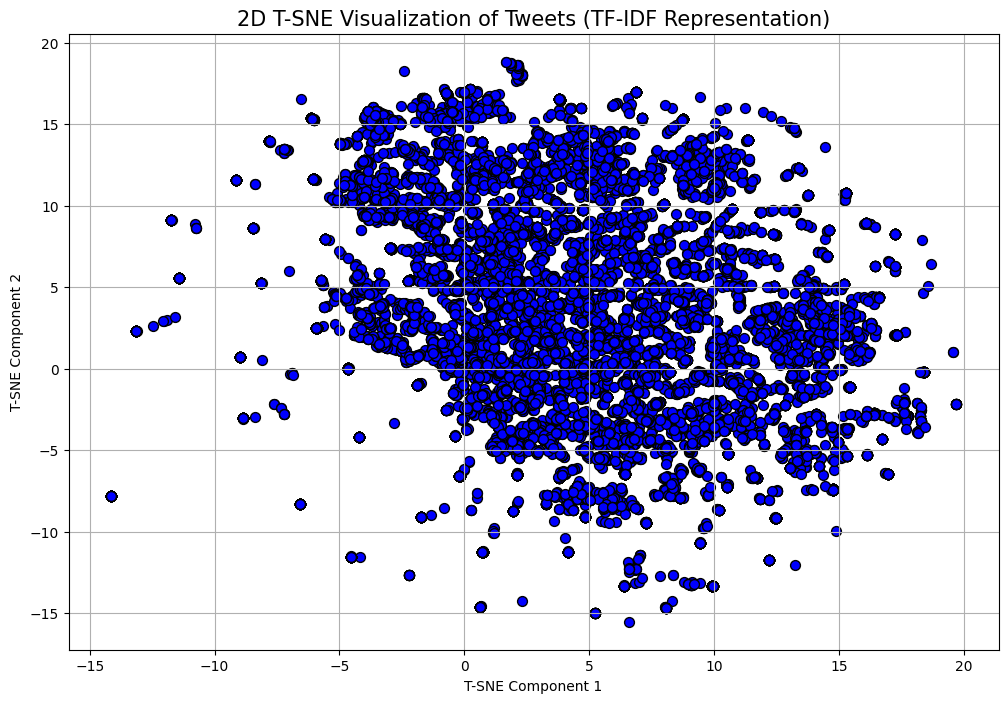

In [ ]:
tweets = tweet_info_df['Tweet'].astype(str).tolist()  # convert to list of strings

# vectorize the tweets using TF-IDF
tfidf_vectorizer = TfidfVectorizer(max_features=30)  # limit to top 30 features
tfidf_matrix = tfidf_vectorizer.fit_transform(tweets)

# apply T-SNE for dimensionality reduction to 2D
perplexity_value = min(30, len(tweets) - 1)  # Set perplexity to a safe value less than the number of samples
tsne = TSNE(n_components=2, random_state=42, perplexity=perplexity_value, max_iter=300)
tweet_embeddings_2d = tsne.fit_transform(tfidf_matrix.toarray())

# 2D scatter plot
plt.figure(figsize=(12, 8))
plt.scatter(tweet_embeddings_2d[:, 0], tweet_embeddings_2d[:, 1], c='blue', edgecolor='k', s=50)
plt.title('2D T-SNE Visualization of Tweets (TF-IDF Representation)', fontsize=15)
plt.xlabel('T-SNE Component 1')
plt.ylabel('T-SNE Component 2')
plt.grid(True)
plt.show()

In the previous plot we can see a graphic which represents tweets based on their TF-IDF vectors, each dot represents an individual tweet positioned according to its word frequency and relevance. Since we can only observe one cluster, this could mean that the tweets may not contain strongly differentiated content based on their TF-IDF scores, or it could be due to T-SNE’s parameter settings. The majority of the points are concentrated near the center, indicating that many tweets share similar word distributions. This makes sense when you consider that they are all about the same topic: the farm protests in India.